Coffea Histograms
===============
In scientific python, histograms seem to be considered as a plot style, on equal footing with, e.g. scatter plots.
It may well be that HEP is the only place where users need to plot *pre-binned* data, and thus must use histograms as persistent objects representing reduced data.  This notebook will discuss a few ways that such objects can be manipulated.

A histogram object roughly goes through three stages in its life:
   - Filling
   - Transformation (projection, rebinning, integrating)
   - Plotting

## Filling
Let's start with filling.  We'll use a random distribution [near and dear](https://en.wikipedia.org/wiki/ARGUS_distribution) to of b and c factory physicists.

In [1]:
import numpy as np
from scipy.stats import argus

vals = argus(chi=.5).rvs(size=1000)

hist = np.histogram(vals)
print(hist)

(array([ 27,  47,  66,  89, 121, 126, 143, 146, 140,  95]), array([0.02929827, 0.12588325, 0.22246824, 0.31905323, 0.41563822,
       0.5122232 , 0.60880819, 0.70539318, 0.80197817, 0.89856315,
       0.99514814]))


So we're done, right?
Probably not: we have more than 1000 events, and probably need to use some map-reduce paradigm to fill the histogram because we can't keep all 1 billion `vals` in memory.  So we need two things: a binning, so that all histograms that were independently created can be added, and the ability to add two histograms.

In [2]:
binning = np.linspace(0, 1, 50)

def add_histos(h1, h2):
    h1sumw, h1binning = h1
    h2sumw, h2binning = h2
    if h1binning.shape == h2binning.shape and np.all(h1binning==h2binning):
        return h1sumw+h2sumw, h1binning
    else:
        raise ValueError("The histograms have inconsistent binning")


In [3]:
vals2 = argus(chi=.5).rvs(size=1000)

hist1 = np.histogram(vals, bins=binning)
hist2 = np.histogram(vals, bins=binning)

hist = add_histos(hist1, hist2)
print(hist)

(array([ 0,  6, 14,  6, 14, 14,  4, 24, 30, 18, 20, 22, 36, 22, 26, 44, 20,
       38, 36, 40, 42, 60, 54, 64, 40, 48, 32, 78, 56, 52, 44, 62, 74, 60,
       60, 72, 56, 40, 82, 60, 62, 64, 56, 54, 40, 72, 26, 38, 18]), array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ]))


So now we have everything we need to make our own TH1, from a filling perspective.

In [4]:
class myTH1:
    def __init__(self, binning):
        self._binning = binning
        self._sumw = np.zeros(binning.size - 1)
    
    def fill(self, values, weights=None):
        sumw, _ = np.histogram(values, bins=self._binning, weights=weights)
        self._sumw += sumw
    
    def __add__(self, other):
        if not isinstance(other, myTH1):
            raise ValueError
        if not np.array_equal(other._binning, self._binning):
            raise ValueError("The histograms have inconsistent binning")
        out = myTH1(self._binning)
        out._sumw = self._sumw + other._sumw
        return out

In [5]:
binning = np.linspace(0, 1, 50)

h1 = myTH1(binning)
h1.fill(vals)

h2 = myTH1(binning)
h2.fill(vals2)

h = h1 + h2
print(h._sumw)

[ 1.  6.  9.  6. 15. 10.  9. 17. 32. 19. 23. 33. 33. 23. 44. 38. 30. 37.
 41. 41. 49. 59. 51. 56. 44. 49. 42. 64. 60. 47. 51. 70. 63. 61. 60. 70.
 62. 41. 71. 54. 55. 54. 48. 68. 37. 58. 32. 36. 21.]


Homework: add `sumw2` support.

Of course, we might want multidimensional histograms.  There is `np.histogramdd`:

In [6]:
xyz = np.random.multivariate_normal(mean=[1, 3, 7], cov=np.eye(3), size=10000)

xbins = np.linspace(-10, 10, 20)
ybins = np.linspace(-10, 10, 20)
zbins = np.linspace(-10, 10, 20)
hnumpy = np.histogramdd(xyz, bins=(xbins, ybins, zbins))

but we are becoming challenged by book-keeping of the variables.
The histogram utility in Coffea is designed to simplify this operation, and the eventual successor (for filling purposes) [boost-histogram](https://github.com/scikit-hep/boost-histogram#usage) has similar syntax.

In [28]:
import coffea.hist as hist

hfcat = hist.Hist("Counts",
                  hist.Cat("sample", "sample name"),
                  hist.Bin("x", "x value", 20, -10, 10),
                  hist.Bin("y", "y value", 20, -10, 10),
                  hist.Bin("z", "z value", 20, -10, 10),
                 )

hfcat.fill(sample="sample 1", x=xyz[:,0], y=xyz[:,1], z=xyz[:,2])

# suppose we have another sample of xyz values
xyz_sample2 = np.random.multivariate_normal(mean=[1, 3, 7], cov=np.eye(3), size=10000)

# additionally, lets assume entries in sample 2 have weight equal to atan(distance from origin)
weight = np.arctan(np.sqrt(np.power(xyz_sample2, 2).sum(axis=1)))

# weight is a reserved keyword in Hist
hfcat.fill(sample="sample 2", x=xyz_sample2[:,0], y=xyz_sample2[:,1], z=xyz_sample2[:,2], weight=weight)

print(hfcat)

<Hist (sample,x,y,z) instance at 0x1296d2518>


In [8]:
# For more details, look at:
# help(hist.Hist)
# help(hist.Bin)
# help(hist.Cat)

## Transformation

Here are a few examples of transformations on multidimensional histograms in Coffea.  For each, the docstring (`help(function)` or shift+tab in Jupyter) provides useful info.

In [9]:
# sum all x bins within nominal range (-10, 10)
hfcat.sum("x", overflow='none')

<Hist (sample,y,z) instance at 0x1229aa400>

There is some analog to fancy array slicing for histogram objects, which is supported (with reasonable consistency) in Coffea, where the slice boundaries are physical axis values, rather than bin indices.  All values outside the slice range are merged into overflow bins.

For a lengthy discussion on possible slicing syntax for the future, see [boost-histogram#35](https://github.com/scikit-hep/boost-histogram/issues/35).

In [10]:
sliced = hfcat[:,0:,4:,0:]
display(sliced)
display(sliced.identifiers("y", overflow='all'))

<Hist (sample,x,y,z) instance at 0x1229aa668>

[<Interval ((-inf, 4)) instance at 0x122986dd8>,
 <Interval ([4, 5)) instance at 0x122986e80>,
 <Interval ([5, 6)) instance at 0x122986eb8>,
 <Interval ([6, 7)) instance at 0x122986ef0>,
 <Interval ([7, 8)) instance at 0x122986f98>,
 <Interval ([8, 9)) instance at 0x122986fd0>,
 <Interval ([9, 10)) instance at 0x122986f28>,
 <Interval ([10, inf)) instance at 0x122986f60>]

In [11]:
# integrate y bins from -2 to +10
hfcat.integrate("y", slice(0, 10))

<Hist (sample,x,z) instance at 0x122970b00>

In [12]:
# rebin z axis by providing a new axis definition
hfcat.rebin("z", hist.Bin("znew", "rebinned z value", [-10, -6, 6, 10]))

<Hist (sample,x,y,znew) instance at 0x128576c18>

In [14]:
# merge categorical axes
mapping = {
    'all samples': ['sample 1', 'sample 2'],
    'just sample 1': ['sample 1'],
}
hfcat.group("sample", hist.Cat("cat", "new category"), mapping)

<Hist (cat,x,y,z) instance at 0x10bb1a160>

In [15]:
# scale entire histogram by 3 (in-place)
hfcat.scale(3.)

In [16]:
# scale samples by different values
scales = {
    'sample 1': 1.2,
    'sample 2': 0.2,
}
hfcat.scale(scales, axis='sample')

In [17]:
# useful debugging tool: print bins, aka 'identifiers'
display(hfcat.identifiers('sample'))
display(hfcat.identifiers('x'))

[<StringBin (sample 1) instance at 0x1285766a0>,
 <StringBin (sample 2) instance at 0x1285766d8>]

[<Interval ([-10, -9)) instance at 0x1229aa9b0>,
 <Interval ([-9, -8)) instance at 0x1229aa9e8>,
 <Interval ([-8, -7)) instance at 0x1229aaa20>,
 <Interval ([-7, -6)) instance at 0x1229aaac8>,
 <Interval ([-6, -5)) instance at 0x1229aad30>,
 <Interval ([-5, -4)) instance at 0x1229aafd0>,
 <Interval ([-4, -3)) instance at 0x1229aab00>,
 <Interval ([-3, -2)) instance at 0x10bb1a080>,
 <Interval ([-2, -1)) instance at 0x128474908>,
 <Interval ([-1, 0)) instance at 0x1284748d0>,
 <Interval ([0, 1)) instance at 0x128571860>,
 <Interval ([1, 2)) instance at 0x1285717b8>,
 <Interval ([2, 3)) instance at 0x1285719b0>,
 <Interval ([3, 4)) instance at 0x1285719e8>,
 <Interval ([4, 5)) instance at 0x128571a20>,
 <Interval ([5, 6)) instance at 0x128571a58>,
 <Interval ([6, 7)) instance at 0x128571a90>,
 <Interval ([7, 8)) instance at 0x128571ac8>,
 <Interval ([8, 9)) instance at 0x128571b00>,
 <Interval ([9, 10)) instance at 0x128571b38>]

In [18]:
# bin contents are accessed using values
hfcat.sum('x', 'y').values(sumw2=False)

{('sample 1',): array([    0. ,     0. ,     0. ,     0. ,     0. ,     0. ,     0. ,
            0. ,     0. ,     0. ,     0. ,     0. ,     0. ,    50.4,
          788.4,  4957.2, 12384. , 12009.6,  5018.4,   774. ]),
 ('sample 2',): array([   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    7.39350147,  171.02689052, 1157.24608438,
        2889.55984047, 3029.19941333, 1196.07062378,  186.15644719])}

In [19]:
# data can be exported to ROOT via uproot, but only 1D (and soon 2D)
import uproot
outputfile = uproot.create("output.root")
h = hfcat.sum('x', 'y')
for sample in h.identifiers('sample'):
    outputfile[sample.name] = hist.export1d(h.integrate('sample', sample))
outputfile.close()

## Plotting
The most integrated plotting utility in the scientific python ecosystem, by far, is [matplotlib](https://matplotlib.org/).  However, as we will see, it is not tailored to HEP needs.  To facilitate the transition, there is a developing package called [mpl-hep](https://github.com/nsmith-/mpl-hep#mpl-hep).  Meanwhile, Coffea tools provide several convenience functions to aid in plotting `Hist` objects.

Let's start by looking at basic mpl histogramming.

In [20]:
# Jupyter display backends for matplotlib: nbagg, inline, etc.
%matplotlib inline
import matplotlib.pyplot as plt

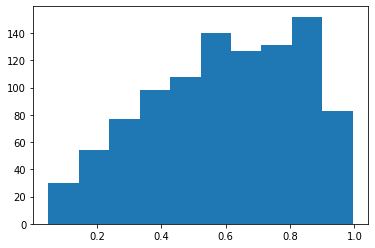

In [21]:
vals = argus(chi=.5).rvs(size=1000)

# notice the semicolon, which prevents display of the return values
plt.hist(vals);

Suppose we want to plot pre-binned data, for example from our earlier `np.histogram` usage.  Here we start running into the edge of typical mpl usage.  As mentioned before, apparently HEP is the only regular user of pre-binned histograms.

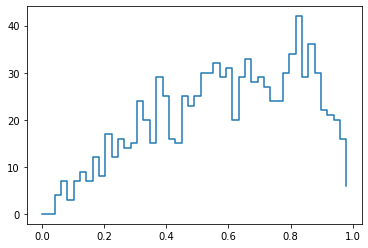

In [22]:
binning = np.linspace(0, 1, 50)

h1vals, h1bins = np.histogram(vals, bins=binning)
plt.step(x=h1bins[:-1], y=h1vals, where='post');

Coffea utilities include a plotting package to aid in displaying pre-binned histograms.  Here are a small set of example plots that can be made using this utility.  More examples can be found in [this notebook](https://github.com/CoffeaTeam/fnal-column-analysis-tools/blob/master/binder/plotting-demo.ipynb).

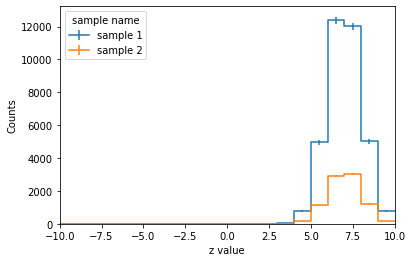

In [23]:
hist.plot1d(hfcat.sum("x", "y"), overlay='sample');

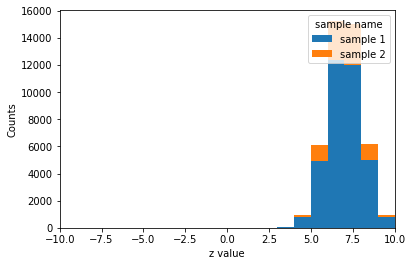

In [24]:
hist.plot1d(hfcat.sum("x", "y"), overlay='sample', stack=True);

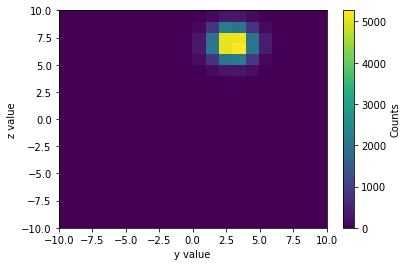

In [25]:
hist.plot2d(hfcat.sum('x', 'sample'), xaxis='y');

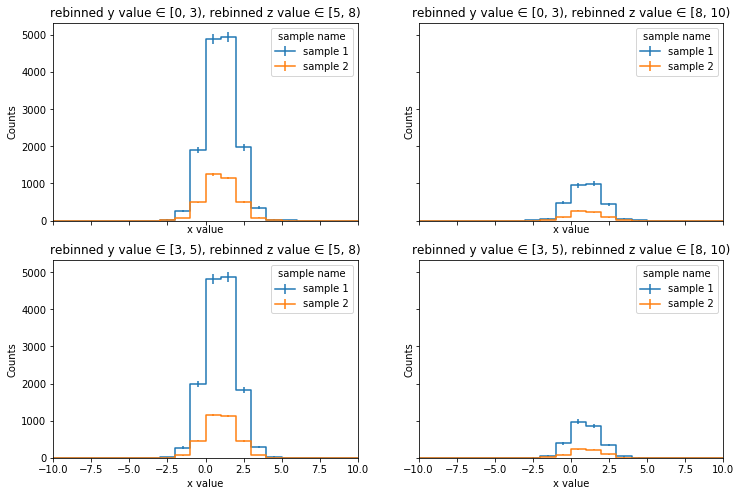

In [26]:
# make coarse binned hist and look at several distributions
hnew = (hfcat.rebin("y", hist.Bin("ynew", "rebinned y value", [0, 3, 5]))
        .rebin("z", hist.Bin("znew", "rebinned z value", [5, 8, 10]))
       )

hist.plotgrid(hnew, row='ynew', col='znew', overlay='sample');

/Users/ncsmith/src/coffea/coffea/hist/plot.py:347: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


(-10, 10)

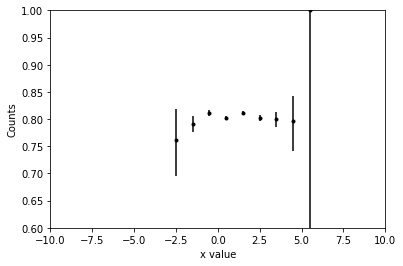

In [27]:
numerator = hfcat.integrate('sample', 'sample 1').sum('y', 'z')
denominator = hfcat.sum('sample', 'y', 'z')

numerator.title = r'$\epsilon$'
fig, ax, _ = hist.plotratio(num=numerator,
                            denom=denominator,
                            error_opts={'color': 'k', 'marker': '.'},
                            unc='clopper-pearson'
                           )
ax.set_ylim(0.6, 1.)
ax.set_xlim(-10, 10)